<html> <h1 style="font-style:bold; color:blue;"> Neural Computing and Deep Learning </h1> </html>

<html> <h1 style="font-style:italic; color:blue;"> Week-12 </h1> </html>

<html> <h2 style="font-style:italic; color:blue;"> Attention Networks </21> </html>

The tutorial will cover the following:

* Preparing a simple dataset for time series forecasting
* How to use a network built via SimpleRNN for time series forecasting
* Adding a custom attention layer to the SimpleRNN network

_________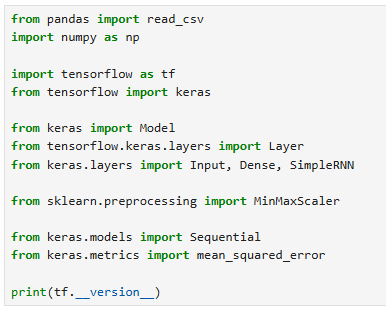

In [1]:
from pandas import read_csv
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from keras import Model
from tensorflow.keras.layers import Layer
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error
print(tf.__version__)

2.17.0


2.18.0


### The Dataset

We will create a fibonacci sequence dataset for our purpose. In Fibonacci sequence, one number is constructed from the previous two numbers. The first 10 numbers of the sequence are shown below:

0, 1, 1, 2, 3, 5, 8, 13, 21, 34, …


When given the previous ‘t’ numbers, can you get a machine to accurately reconstruct the next number? This would mean discarding all the previous inputs except the last two and performing the correct operation on the last two numbers.

For this tutorial, you’ll construct the training examples from t time steps and use the value at t+1 as the target. For example, if t=3, then the training examples and the corresponding target values would look as follows:


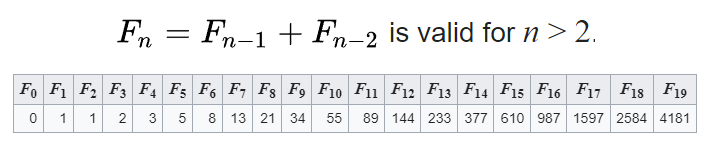

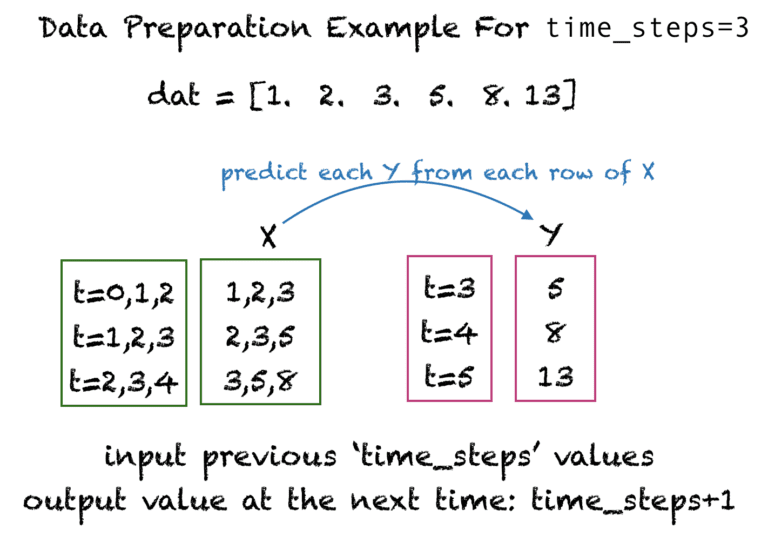

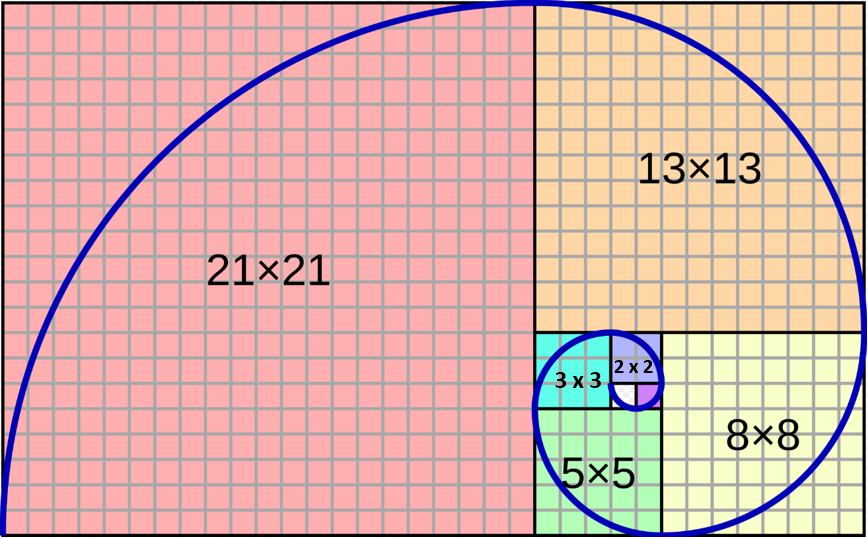

The Fibonacci spiral: an approximation of the **golden spiral** created by drawing circular arcs connecting the opposite corners of squares in the Fibonacci tiling

### Data preprocessing

_____________________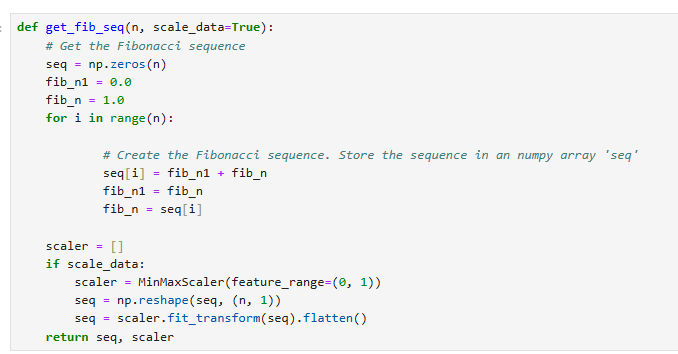

In [2]:
def get_fib_seq (n, scale_data=True):
    #get the Fibonacci sequence 
    seq=np.zeros(n)
    fib_n1=0.0
    fib_n=1.0
    for i in range(n):
        #create the F sequence. Store the sequence in an numpy array "seq"
        seq[i]=fib_n1+fib_n
        fib_n1=fib_n
        fib_n=seq[i]
    scaler=[]
    if scale_data:
        scaler=MinMaxScaler(feature_range=(0,1))
        seq=np.reshape(seq,(n,1))
        seq=scaler.fit_transform(seq).flatten()
    return seq,  scaler

#### Hint:

You can copy blocks of code in the cells above and cells from previous weeks of practice sessions.

Some are easy enough to copy, some need to be slightly modified. This can speed up your code creation.

In [2]:
# Check if the function works correctly:
# Copy the previous cell, change the function name and add fib_n 

________________________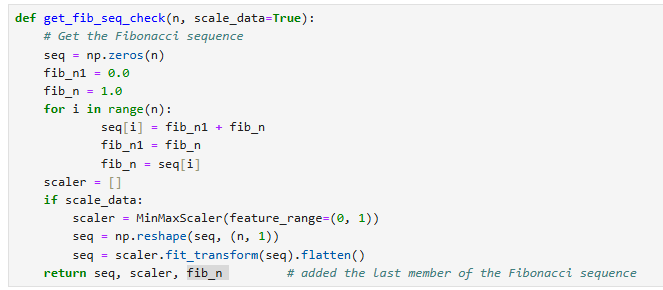

In [3]:
def get_fib_seq_check (n, scale_data=True):
    #get the Fibonacci sequence 
    seq=np.zeros(n)
    fib_n1=0.0
    fib_n=1.0
    for i in range(n):
        #create the F sequence. Store the sequence in an numpy array "seq"
        seq[i]=fib_n1+fib_n
        fib_n1=fib_n
        fib_n=seq[i]
    scaler=[]
    if scale_data:
        scaler=MinMaxScaler(feature_range=(0,1))
        seq=np.reshape(seq,(n,1))
        seq=scaler.fit_transform(seq).flatten()
    return seq,  scaler, fib_n 

_________________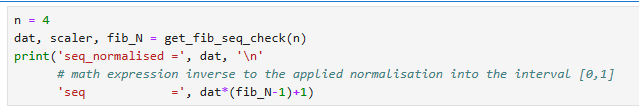

In [4]:
n=4
dat, scaler, fib_N=get_fib_seq_check(n)
print('seq_normalised=', dat, '\n'
      'seq           =', dat*(fib_N-1)+1)

seq_normalised= [0.   0.25 0.5  1.  ] 
seq           = [1. 2. 3. 5.]


seq_normalised = [0.   0.25 0.5  1.  ] 
seq            = [1. 2. 3. 5.]


In [5]:
# Your code for the same checking with n=6 

n=6
dat, scaler, fib_N=get_fib_seq_check(n)
print('seq_normalised=', dat, '\n'
      'seq           =', dat*(fib_N-1)+1)

seq_normalised= [0.         0.08333333 0.16666667 0.33333333 0.58333333 1.        ] 
seq           = [ 1.  2.  3.  5.  8. 13.]


seq_normalised = [0.         0.08333333 0.16666667 0.33333333 0.58333333 1.        ] 
seq            = [ 1.  2.  3.  5.  8. 13.]


In [6]:
# Your code for the same checking with n=8 

n=8
dat, scaler, fib_N=get_fib_seq_check(n)
print('seq_normalised=', dat, '\n'
      'seq           =', dat*(fib_N-1)+1)

seq_normalised= [0.         0.03030303 0.06060606 0.12121212 0.21212121 0.36363636
 0.60606061 1.        ] 
seq           = [ 1.  2.  3.  5.  8. 13. 21. 34.]


seq_normalised = [0.         0.03030303 0.06060606 0.12121212 0.21212121 0.36363636
 0.60606061 1.        ] 
seq            = [ 1.  2.  3.  5.  8. 13. 21. 34.]


In [7]:
# Your code for the same checking with n=10 

n=10
dat, scaler, fib_N=get_fib_seq_check(n)
print('seq_normalised=', dat, '\n'
      'seq           =', dat*(fib_N-1)+1)

seq_normalised= [0.         0.01136364 0.02272727 0.04545455 0.07954545 0.13636364
 0.22727273 0.375      0.61363636 1.        ] 
seq           = [ 1.  2.  3.  5.  8. 13. 21. 34. 55. 89.]


seq_normalised = [0.         0.01136364 0.02272727 0.04545455 0.07954545 0.13636364
 0.22727273 0.375      0.61363636 1.        ] 
seq            = [ 1.  2.  3.  5.  8. 13. 21. 34. 55. 89.]


___________________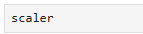

MinMaxScaler()

### The following function transforms the fibonacci sequence into training and test dataset.

X and Y looks like the following. From X and Y, we create training and test dataset.


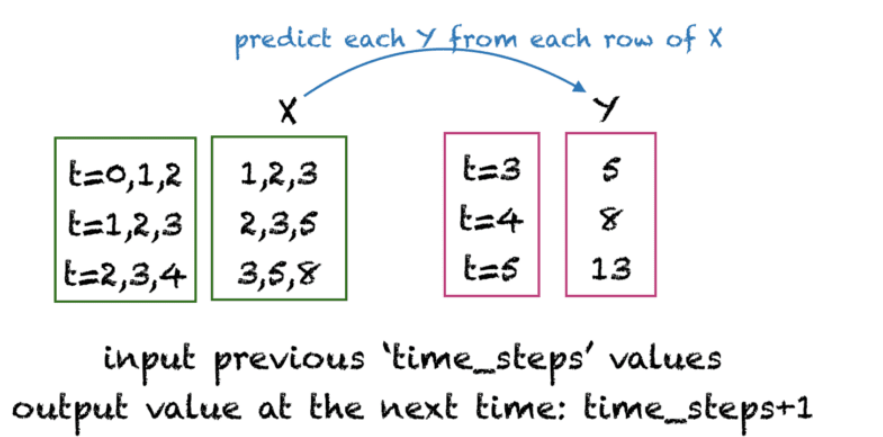

____________________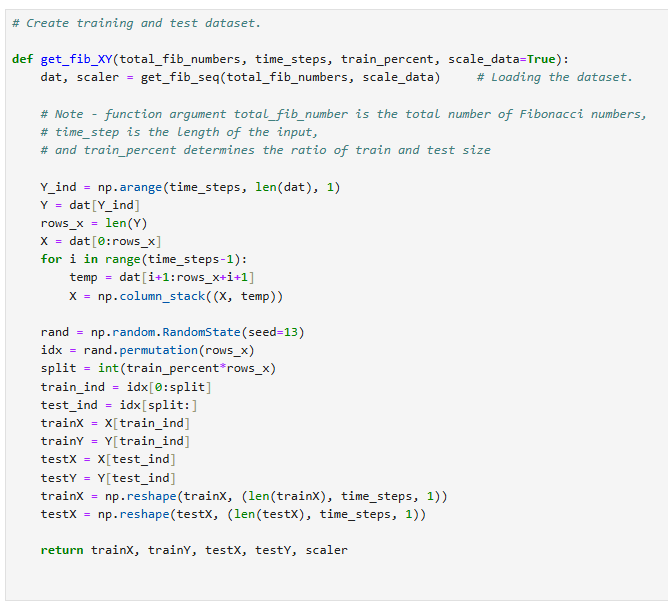

In [8]:
def get_fib_XY(total_fib_numbers, time_steps, train_percent, scale_data=True):
    dat, scaler = get_fib_seq(total_fib_numbers, scale_data)

    Y_ind=np.arange(time_steps, len(dat), 1)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[0:rows_x]
    for i in range(time_steps -1):
        temp = dat[i+1:rows_x+i+1]
        X = np.column_stack((X, temp))

    rand = np.random.RandomState(seed=13)
    idx = rand.permutation(rows_x)
    split = int(train_percent*rows_x)
    train_ind = idx[0:split]
    test_ind = idx[split:]
    trainX = X[train_ind]
    trainY = Y[train_ind]
    testX = X[test_ind]
    testY = Y[test_ind]
    trainX = np.reshape(trainX, (len(trainX), time_steps, 1))
    testX = np.reshape(testX, (len(testX), time_steps, 1))

    return trainX, trainY, testX, testY, scaler

_________________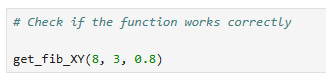

In [9]:
get_fib_XY(8, 3, 0.8)

(array([[[0.03030303],
         [0.06060606],
         [0.12121212]],
 
        [[0.12121212],
         [0.21212121],
         [0.36363636]],
 
        [[0.21212121],
         [0.36363636],
         [0.60606061]],
 
        [[0.        ],
         [0.03030303],
         [0.06060606]]]),
 array([0.21212121, 0.60606061, 1.        , 0.12121212]),
 array([[[0.06060606],
         [0.12121212],
         [0.21212121]]]),
 array([0.36363636]),
 MinMaxScaler())

(array([[[0.03030303],
         [0.06060606],
         [0.12121212]],
 
        [[0.12121212],
         [0.21212121],
         [0.36363636]],
 
        [[0.21212121],
         [0.36363636],
         [0.60606061]],
 
        [[0.        ],
         [0.03030303],
         [0.06060606]]]),
 array([0.21212121, 0.60606061, 1.        , 0.12121212]),
 array([[[0.06060606],
         [0.12121212],
         [0.21212121]]]),
 array([0.36363636]),
 MinMaxScaler())

In [29]:
#np.column_stack?

In [31]:
#np.random.RandomState.permutation?

### In the following code, we test the performance with the help of a simple RNN.


#### Set up parameters

__________________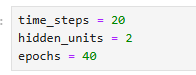

In [10]:
time_steps = 20
hidden_units = 2
epochs = 40

#### Create a traditional RNN network

______________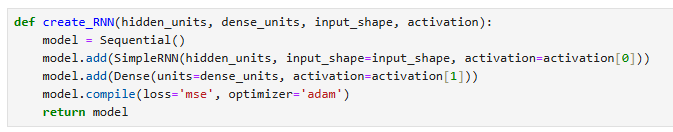

In [11]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model

___________________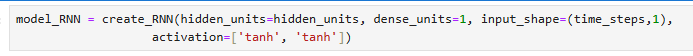

In [12]:
model_RNN = create_RNN(hidden_units=hidden_units, dense_units=1, input_shape=(time_steps, 1),
         activation = ['tanh', 'tanh'])

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


C:\Users\vital\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


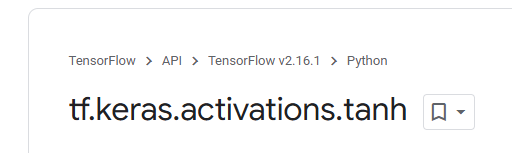
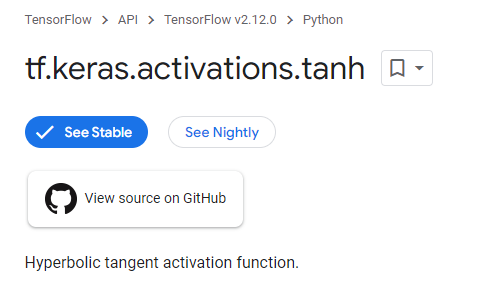

##### tf.keras.activations.tanh

https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh

In [13]:
# Your code to print the model summary

model_RNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 2)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11 (44.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 2)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11 (44.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 0 (0.00 B)

________________________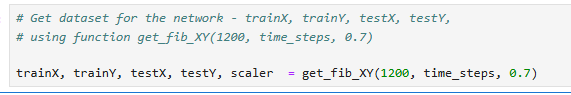

In [14]:
trainX, trainY, testX, testY, scaler = get_fib_XY(1200, time_steps, 0.7)

#### Train the network

_____________________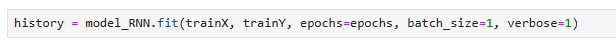

In [15]:
history = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.7659e-04
Epoch 2/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0093
Epoch 3/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0026
Epoch 4/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5167e-04
Epoch 5/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0011  
Epoch 6/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073
Epoch 7/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0018
Epoch 8/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0011
Epoch 9/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0024
Epoch 10/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0029
Epoch 11/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0011
Epoch 12/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0013
Epoch 13/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.2869e-04
Epoch 14/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7647e-04
Epoch 15/40
826/826 ━━━━━━━━━━━━━━━━━━━

Epoch 1/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 6.7742e-04
Epoch 2/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 9.7887e-04
Epoch 3/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 2.7872e-04
Epoch 4/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 6.9042e-04
Epoch 5/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0015
Epoch 6/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 3.1846e-04
Epoch 7/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 6.1769e-05
Epoch 8/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 5.8370e-04
Epoch 9/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 5.6659e-04
Epoch 10/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 1.4832e-04
Epoch 11/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 8.2686e-04
Epoch 12/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 4.7799e-04
Epoch 13/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 3.2870e-05
Epoch 14/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/s

____________________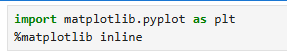

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Hint:

You can copy blocks of code in the cells above and cells from previous weeks of practice sessions.

Some are easy enough to copy, some need to be slightly modified. This can speed up your code creation.

___________________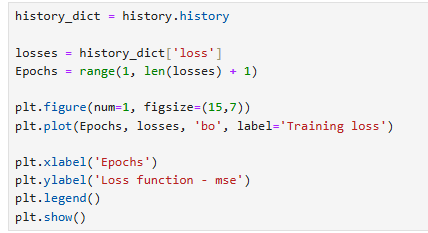

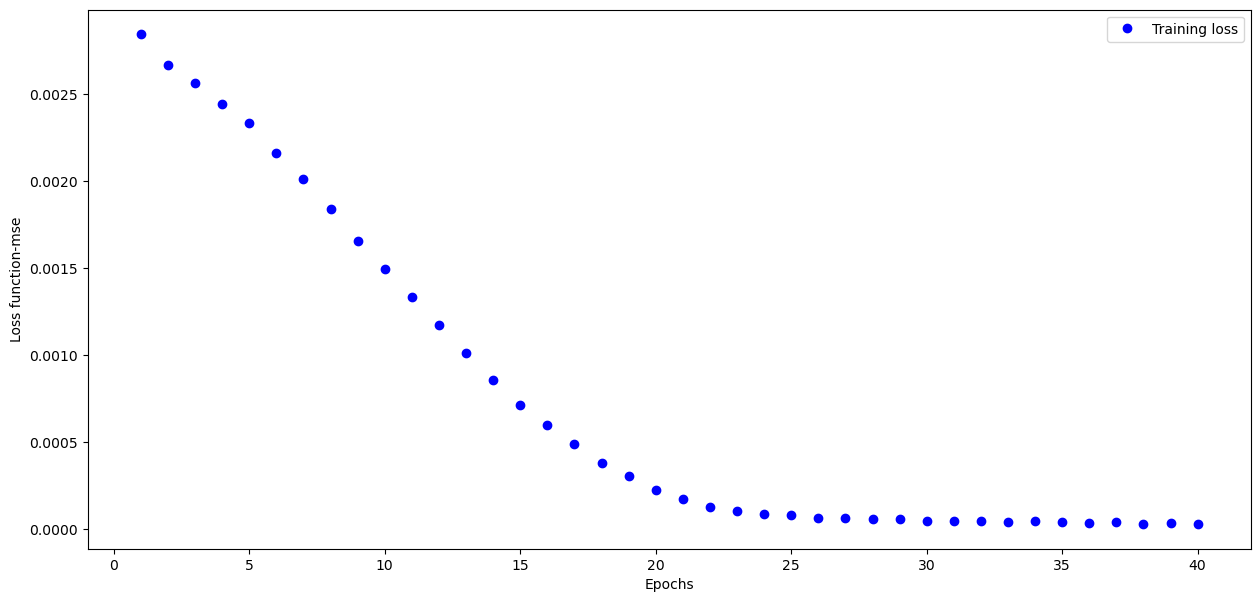

In [17]:
history_dict=history.history
losses=history_dict['loss']
Epochs=range(1, len(losses)+1)
plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs, losses, 'bo', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function-mse')
plt.legend()
plt.show()

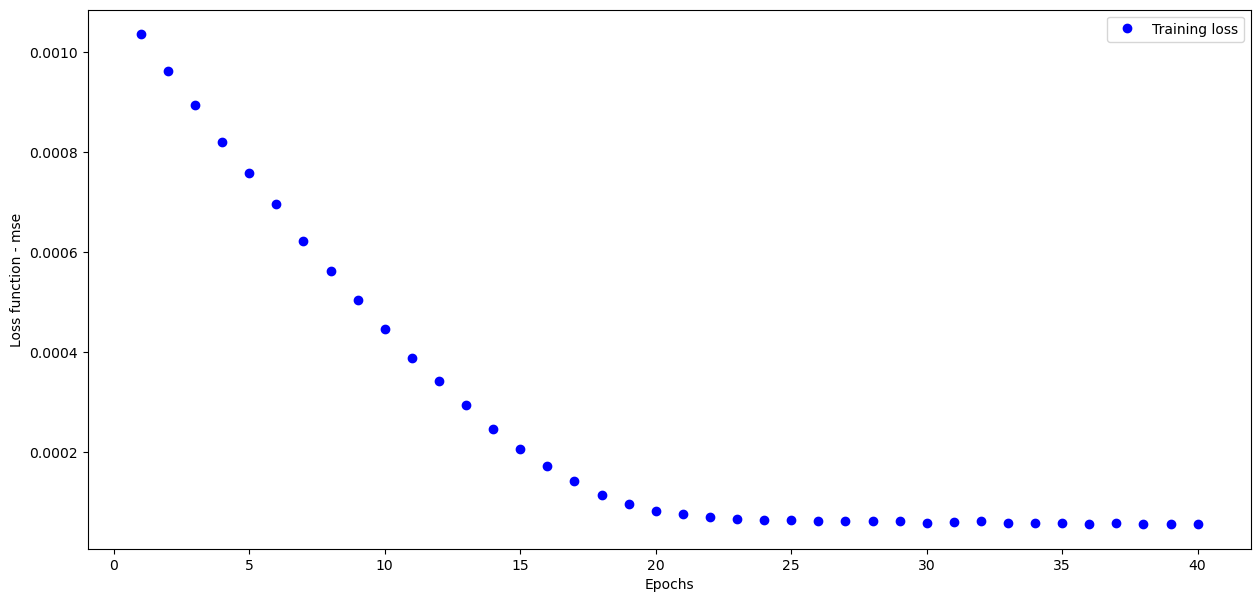

#### Evalute model

____________________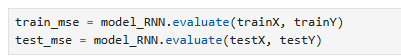

In [18]:
train_mse=model_RNN.evaluate(trainX, trainY)
test_mse=model_RNN.evaluate(testX, testY)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1821e-05  
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1599e-05 


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5865e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1628e-05


#### Print train and test error metrics

__________________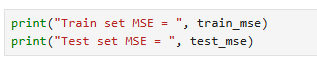

In [19]:
print(train_mse)
print(test_mse)

2.204198608524166e-05
1.6043482901295647e-05


In [54]:
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

Train set MSE =  4.628741226042621e-05
Test set MSE =  2.7580872483667918e-05


### The following code creates an attention layer. You need to understand each line to know how an attention layer can be created. 


_____________________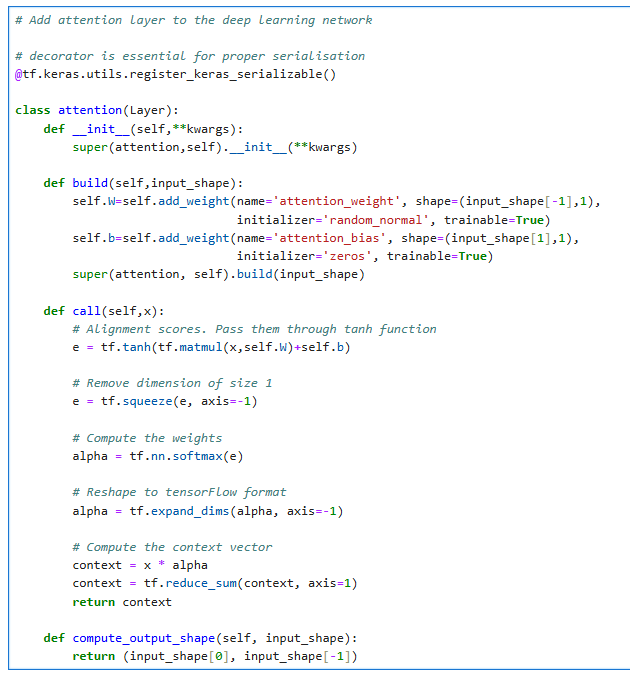

In [20]:
@tf.keras.utils.register_keras_serializable()

class attention(Layer):
    def __init__(self, **kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight',shape=(input_shape[-1], 1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
        initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W)+self.b)

        e = tf.squeeze(e, axis=-1)

        alpha = tf.nn.softmax(e)

        alpha = tf.expand_dims(alpha, axis=-1)
        context = x*alpha
        context = tf.reduce_sum(context, axis=1)
        return context
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

### The following code develops an RNN with an attention layer to predict the Fibonacci sequence.



________________________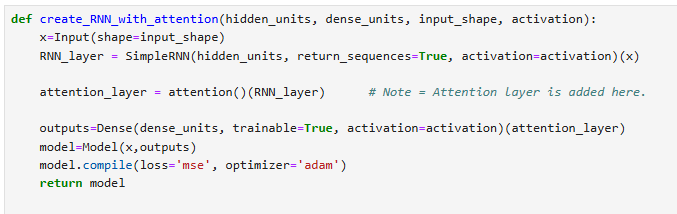

In [21]:
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x = Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)

    attention_layer = attention()(RNN_layer)

    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model= Model(x, outputs)
    model.compile(loss='mse', optimizer='adam')
    return model


________________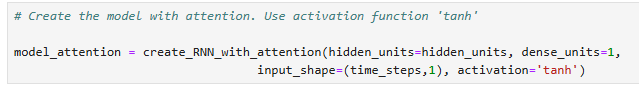

In [22]:
model_attention = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1,
                                            input_shape=(time_steps,1), activation='tanh')


In [23]:
# Your code to print the model summary

model_attention.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 2)          │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (attention)           │ (None, 2)              │            22 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 2)          │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (attention)           │ (None, 2)              │            22 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Your code to fit the model
# save the results of the training to 'history_2' variable list
# use batch_size=1

history_2 = model_attention.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.1823e-04
Epoch 2/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0046
Epoch 3/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0063
Epoch 4/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8024e-04
Epoch 5/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3560e-04
Epoch 6/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0026
Epoch 7/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.7202e-04
Epoch 8/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1742e-04
Epoch 9/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.3964e-04
Epoch 10/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1864e-04
Epoch 11/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0021
Epoch 12/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0010
Epoch 13/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.3572e-04
Epoch 14/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7054e-04
Epoch 15/40
826/826 ━

Epoch 1/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 3.2974e-04
Epoch 2/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0039
Epoch 3/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 5.6386e-04
Epoch 4/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0013
Epoch 5/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 9.8941e-04
Epoch 6/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 8.4034e-04
Epoch 7/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 9.3901e-04
Epoch 8/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 9.7015e-04
Epoch 9/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 1.1484e-04
Epoch 10/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 3.2739e-05
Epoch 11/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 6.6941e-04
Epoch 12/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0012
Epoch 13/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 4.9196e-04
Epoch 14/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - lo

#### Hint:

You can copy blocks of code in the cells above and cells from previous weeks of practice sessions.

Some are easy enough to copy, some need to be slightly modified. This can speed up your code creation.


_______________________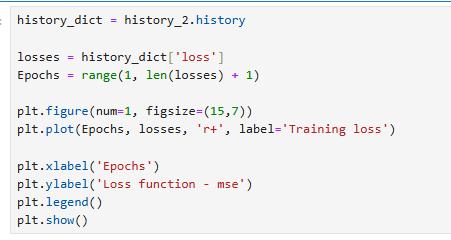

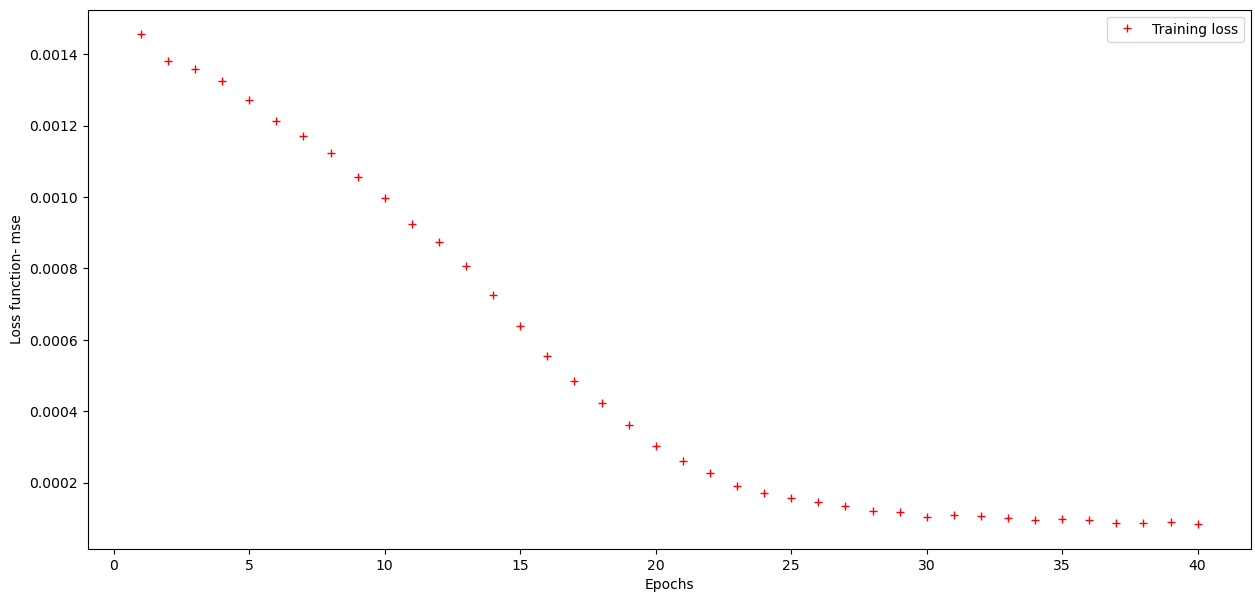

In [25]:
history_dict=history_2.history
losses=history_dict['loss']
Epochs=range(1, len(losses)+1)
plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs, losses, 'r+', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function- mse')
plt.legend()
plt.show()

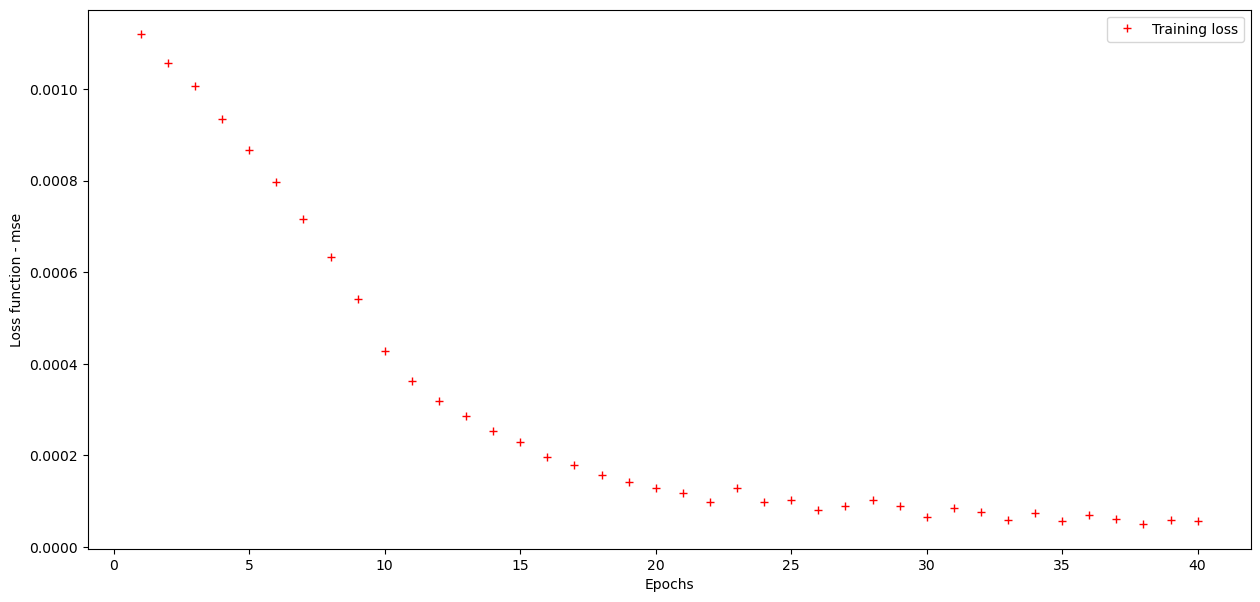

In [26]:
# Your code to Evaluate attention model on training set
# Your code to evaluate the attention model on the test set


train_mse_attn=model_attention.evaluate(trainX, trainY)
test_mse_attn=model_attention.evaluate(testX, testY)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1710e-05 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7320e-05 


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.0459e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3489e-05


In [27]:
# Your code to print train error metric
# Your code to print test error metric

print(train_mse_attn, test_mse_attn)

6.298678636085242e-05 1.3783354006591253e-05


Train set MSE with attention =  3.645733158919029e-05
Test set MSE with attention =  2.13204857573146e-05


In [ ]:
# Draw both loss functions' graphs together

________________________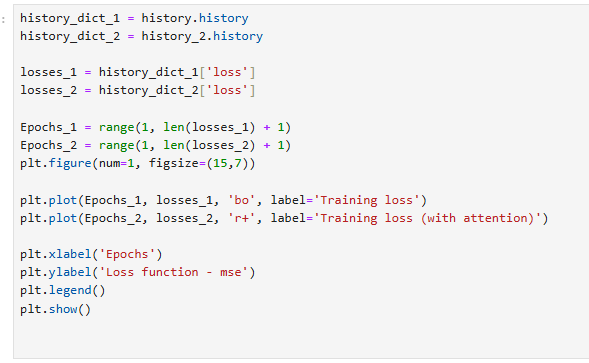

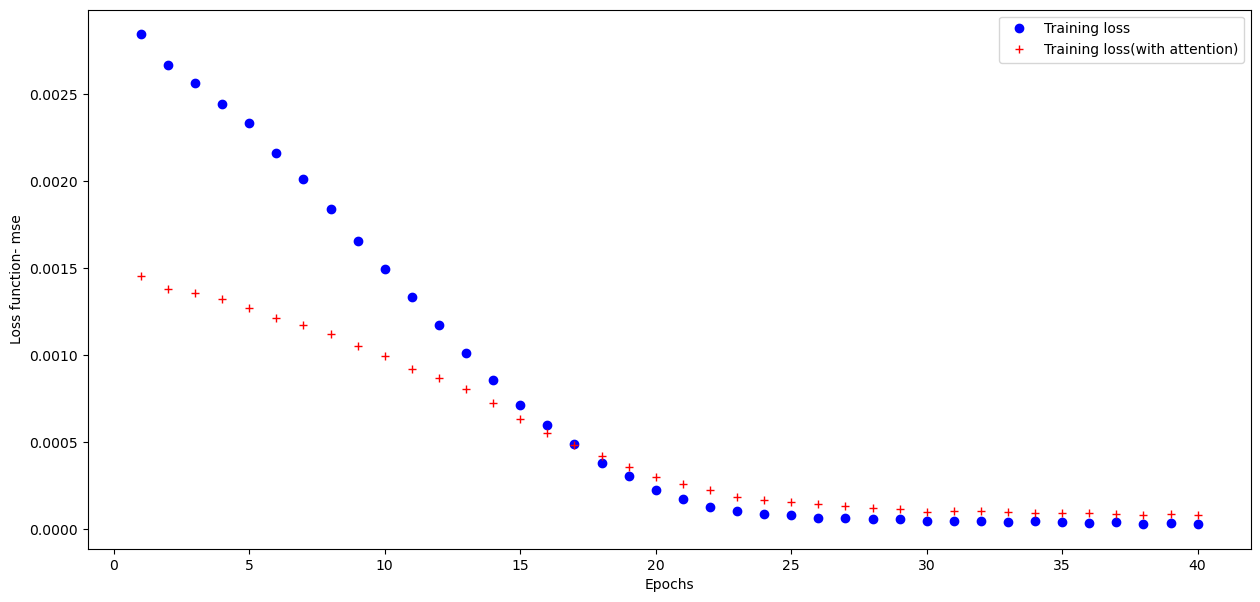

In [28]:
history_dict_1=history.history
history_dict_2=history_2.history

losses_1=history_dict_1['loss']
losses_2=history_dict_2['loss']

Epochs_1=range(1, len(losses_1)+1)
Epochs_2=range(1, len(losses_2)+1)
plt.figure(num=1, figsize=(15,7))

plt.plot(Epochs_1, losses_1, 'bo', label='Training loss')
plt.plot(Epochs_2, losses_2, 'r+', label='Training loss(with attention)')

plt.xlabel('Epochs')
plt.ylabel('Loss function- mse')
plt.legend()
plt.show()

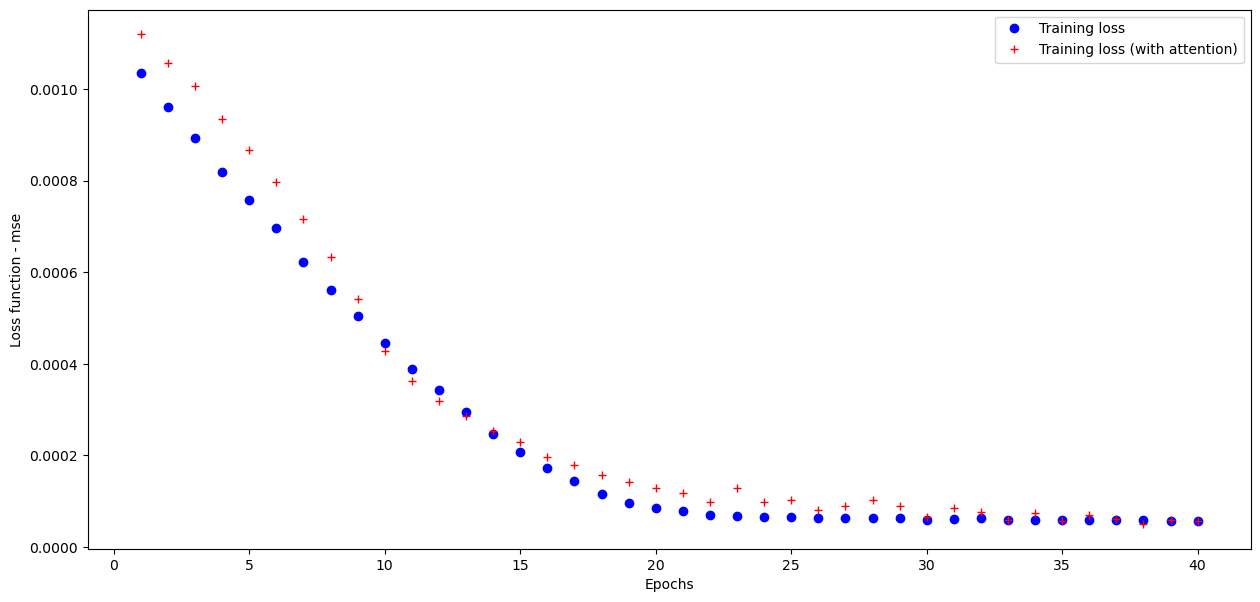

### Plot the train and test MSE performance for the 'Simple RNN' and 'RNN with an attention layer'.


_________________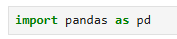

In [29]:
import pandas as pd

_______________________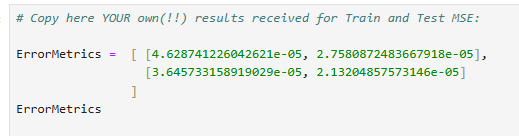

In [ ]:
ErrorMetrics_pd=pd.DataFrame([[0.00011618099961197004, 1.0066521099361125e-05],
                               [4.940701910527423e-05, 2.1152161934878677e-05]
                              ])
ErrorMetrics_pd

[[4.628741226042621e-05, 2.7580872483667918e-05],
 [3.645733158919029e-05, 2.13204857573146e-05]]

____________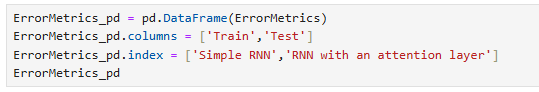

In [ ]:
ErrorMetrics_pd.columns=['Train', 'Test']
ErrorMetrics_pd.index=['Simple RNN','RNN with an attention layer']
ErrorMetrics_pd

,Train,Test
Simple RNN,0.000046,0.000028
RNN with an attention layer,0.000036,0.000021


In [35]:
## MSE performance histogram

__________________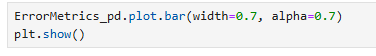

In [ ]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)
plt.show()

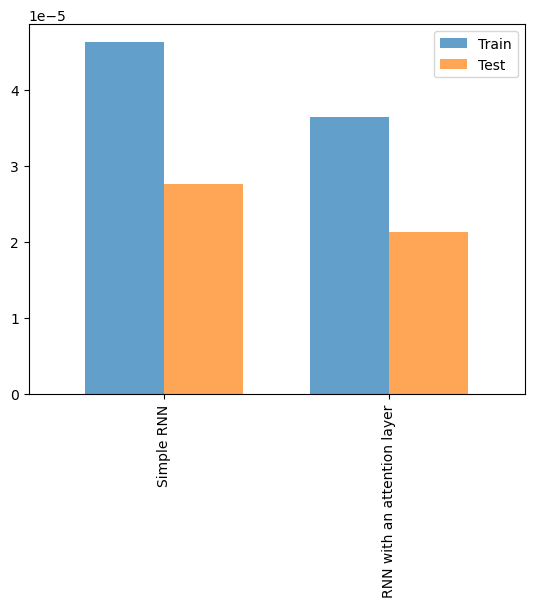

# Lab Logbook Requirement:

<html> <h3 style="; color:blue;">

1) Modify the training parameter of the RNN with an attention layer model using the following formulas:

Modify the number of epochs:
Z + 50
, where your SID is: XXXXXXZ

Use EarlyStopping() and ModelCheckpoint() function to save the best modetl in the file 'best_attention_model.keras' 
Modify the patience parameter:
Z + 10
, where your SID is: XXXXXXZ

2) Modify time_steps = 20 and hidden_units = 4
3) Leave other parameters the same as in the practical session
4) Calculate and demonstrate the received loss for train and test datasets
5) Plot the Loss function (MSE) graph during the training process for the 3 models together
6) Please only add to your Lab Logbook print-screens of:
- calculation of your parameters
- your code of using EarlyStopping() and ModelCheckpoint() functions
- your code and training result using model.fit()
- received loss for train and test datasets
- Loss (MSE) graph for the 3 models together during the training process
- performance histogram for train and test loss (MSE) of the 3 models together


</h3> </html>


<html> <h3 style="color:red;">
NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK ON GITHUB OR ONEDRIVE.
</h3> </html>

### Test the above model with different parameters, layer size, train and test ratio, and time steps.



__________________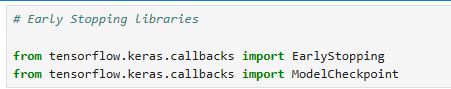

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

________________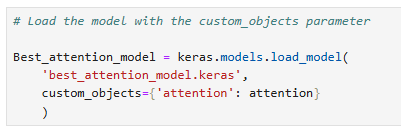

In [31]:
# Your code of parameter modification

# time_steps = 20

# hidden_units = 4

# epochs = 58

# patience =18

model_attention3 = create_RNN_with_attention(hidden_units=4, dense_units=1,
                                            input_shape=(20,1), activation='tanh')


In [32]:
# Continue your code according to the Lab Logbook Requirements ...
es = EarlyStopping(monitor='val_loss', patience=18, restore_best_weights=True)
cp = ModelCheckpoint('best_attention_model.keras.h5', monitor='val_loss', save_best_only=True)

In [33]:
history_3 = model_attention3.fit(trainX, trainY, epochs=58, batch_size=1, callbacks=[es,cp], verbose=1)

Epoch 1/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0017
Epoch 2/58
 76/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.7122e-04

C:\Users\User\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
C:\Users\User\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.5027e-04
Epoch 3/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2023e-04
Epoch 4/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0038
Epoch 5/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7518e-04
Epoch 6/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2404e-04
Epoch 7/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1989e-04
Epoch 8/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0042
Epoch 9/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0033
Epoch 10/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012
Epoch 11/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0025
Epoch 12/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2523e-04
Epoch 13/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.6883e-04
Epoch 14/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0015
Epoch 15/58
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0278e-04
Epoch 16/58
826/826 ━━━━━━━━━━━━━━━

In [34]:
train_mse_attn3=model_attention3.evaluate(trainX, trainY)
test_mse_attn3=model_attention3.evaluate(testX, testY)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8518e-05  
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6258e-05 


In [35]:
print(train_mse_attn3, test_mse_attn3)

2.7687723559211008e-05 1.675581734161824e-05


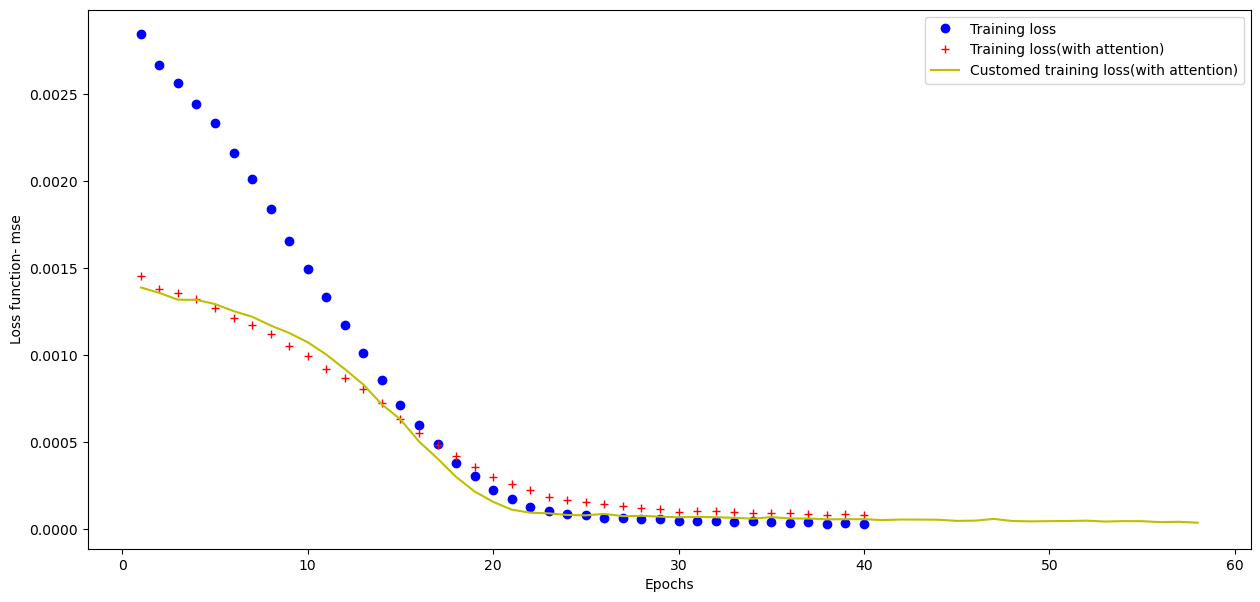

In [36]:
history_dict_1=history.history
history_dict_2=history_2.history
history_dict_3=history_3.history
losses_1=history_dict_1['loss']
losses_2=history_dict_2['loss']
losses_3=history_dict_3['loss']
Epochs_1=range(1, len(losses_1)+1)
Epochs_2=range(1, len(losses_2)+1)
Epochs_3=range(1, len(losses_3)+1)
plt.figure(num=1, figsize=(15,7))

plt.plot(Epochs_1, losses_1, 'bo', label='Training loss')
plt.plot(Epochs_2, losses_2, 'r+', label='Training loss(with attention)')
plt.plot(Epochs_3, losses_3, 'y', label='Customed training loss(with attention)')
plt.xlabel('Epochs')
plt.ylabel('Loss function- mse')
plt.legend()
plt.show()

In [37]:
ErrorMetrics_pd=pd.DataFrame([[2.204198608524166e-05, 1.6043482901295647e-05],
                               [6.298678636085242e-05, 1.3783354006591253e-05],
                              [2.7687723559211008e-05, 1.675581734161824e-05]
                              ])
ErrorMetrics_pd

,0,1
0,0.000022,0.000016
1,0.000063,0.000014
2,0.000028,0.000017


In [38]:
ErrorMetrics_pd.columns=['Train', 'Test']
ErrorMetrics_pd.index=['Simple RNN','RNN with an attention layer', 'Customed RNN']
ErrorMetrics_pd

,Train,Test
Simple RNN,0.000022,0.000016
RNN with an attention layer,0.000063,0.000014
Customed RNN,0.000028,0.000017


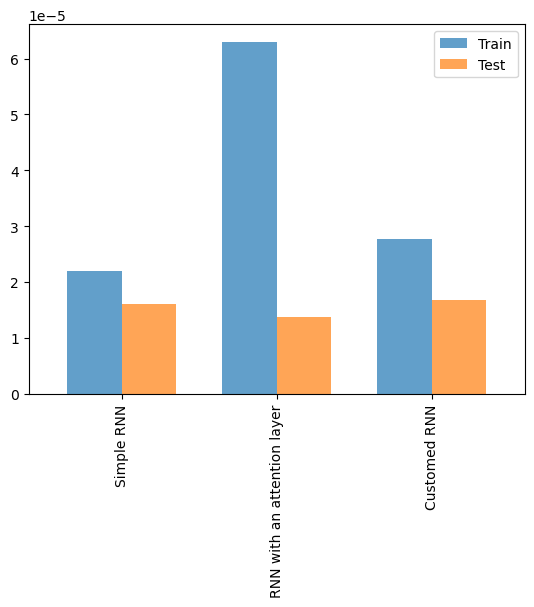

In [39]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)
plt.show()